In [1]:
#
# import necessary packages
#

import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import textwrap
from numpy import argmax
from random import randint
from tqdm import tqdm
from board_manager import BoardManager, write_model_as_c_header_file

In [ ]:
#
# create randomized boards for training
#

# tile_count is the number of horizontal / vertical tiles ... a tile_count of 4 means a 4x4 board
tile_count = 4

# round_count is the number of rounds of random boards to generate
round_count = 10000

# random_step_count is the number of random moves from "solved orientation" to "randomized orientation"
# . each move will generate a board for training with move
# . that move is the move that brings the border from previous "less randomized" orientation to the "more randomized" orientation
random_step_count = 20

# show_values is a flag to show the board values as they are generated
show_values = round_count <= 2

# boards captures the "input" board orientations
# .  0  1  2  3
# .  4  5  6  7
# .  8  9 10 11
# . 12 13 14 15
boards = np.empty((0, tile_count * tile_count), int)
# moves captures the "label" moves -- 0: from left; 1: from right; 2: from top; 3: from bottom)
moves = np.empty(0, int)

for round in tqdm(range(round_count)):
  board_manager = BoardManager(tile_count)
  if show_values:
    print(f"[{round}] - ---")
    board_manager.show_board()
  for _ in range(random_step_count):
    move = board_manager.randomize_board_step()
    if show_values:
      print(f"[{round}] - move: {move}")
      board_manager.show_board()
    boards = np.append(boards, [board_manager.board_tiles], axis=0)
    moves = np.append(moves, move)



100%|██████████| 10000/10000 [10:30<00:00, 15.87it/s]


In [3]:
#
# turn the boards and moves into training, validation, and test sets
#

x_values = boards.astype('float32') / (tile_count * tile_count)
y_values = keras.utils.to_categorical(moves, 4)

print(f"* x_values shape: {x_values.shape}")
if show_values:
  print(f"* x_values:")
  print(textwrap.indent(str(x_values), "    "))

print(f"* y_values shape: {y_values.shape}")
if show_values:
  print(f"* y_values:")
  print(textwrap.indent(str(y_values), "    "))

# randomize the order of the INPUT-OUTPUT pairs
indices = np.random.permutation(x_values.shape[0])
x_values = x_values[indices]
y_values = y_values[indices]


* x_values shape: (200000, 16)
* y_values shape: (200000, 4)


In [4]:
#
# turn the INPUT/OUTPUT into training, validation, and test sets
#

total_sample_count = round_count * random_step_count

TRAIN_SPLIT =  int(0.6 * total_sample_count)
TEST_SPLIT = int(0.2 * total_sample_count + TRAIN_SPLIT)

x_train, x_validate, x_test = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_validate, y_test = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

print(f"* x_train shape: {x_train.shape}")
print(f"* x_validate shape: {x_validate.shape}")
print(f"* x_test shape: {x_test.shape}")

print(f"* y_train shape: {y_train.shape}")
print(f"* y_validate shape: {y_validate.shape}")
print(f"* y_text shape: {y_test.shape}")

* x_train shape: (120000, 16)
* x_validate shape: (40000, 16)
* x_test shape: (40000, 16)
* y_train shape: (120000, 4)
* y_validate shape: (40000, 4)
* y_text shape: (40000, 4)


In [ ]:
#
# build a DL model to train on the boards and moves
#

batch_size = 128
epochs = 100

model = keras.models.Sequential()
model.add(keras.layers.Dense(256, activation='relu', input_shape=(tile_count * tile_count,)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(4, activation='softmax'))


model.summary()

c:\Users\trevorlee\Documents\MyProjects\Git\ESP32SlidingPuzzle\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,172 (278.02 KB)

 Trainable params: 71,172 (278.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#
# train the model
#

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_validate, y_validate))

print("====================")
evaluation = model.evaluate(x_test, y_test)
print(f"* evaluation -- {round_count}/{random_step_count}-{tile_count}/{batch_size}/{epochs}: {evaluation}")
print("====================")


Epoch 1/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4672 - loss: 1.1854 - val_accuracy: 0.6609 - val_loss: 0.8596
Epoch 2/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6708 - loss: 0.8360 - val_accuracy: 0.7125 - val_loss: 0.7197
Epoch 3/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7170 - loss: 0.7332 - val_accuracy: 0.7681 - val_loss: 0.6355
Epoch 4/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7497 - loss: 0.6594 - val_accuracy: 0.7920 - val_loss: 0.5669
Epoch 5/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7710 - loss: 0.6081 - val_accuracy: 0.8079 - val_loss: 0.5227
Epoch 6/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7893 - loss: 0.5667 - val_accuracy: 0.8181 - val_loss: 0.4928
Epoch 7/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8014 - loss: 0.5371 - val_accuracy: 0.8257 - val_loss: 0.4752
Epoch 8/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8096 - loss: 0.5150 - val_accu

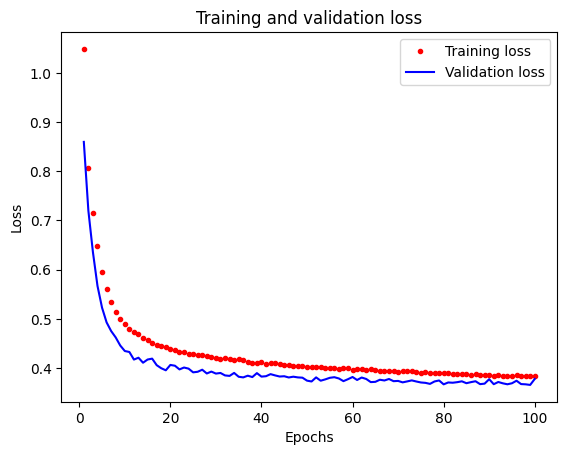

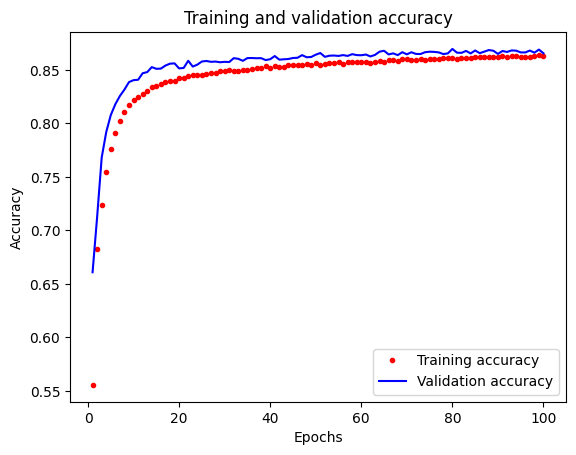

In [12]:
#
# show the training loss and accuracy
#

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'r.', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [13]:
#
# test the model with a board randomized with a single step
#

board_manager = BoardManager(tile_count)
board_manager.randomize_board_step()
board_manager.show_board()

x = np.array([board_manager.board_tiles]).astype('float32') / (tile_count * tile_count)
prediction = model.predict(x)[0]
ans = argmax(prediction)
print(f"*  {prediction} ==> {ans}")

---------------------
|  1 |  0 |  2 |  3 |
|  4 |  5 |  6 |  7 |
|  8 |  9 | 10 | 11 |
| 12 | 13 | 14 | 15 |
---------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
*  [9.9879646e-01 6.9440447e-04 5.1991966e-10 5.0911587e-04] ==> 0


In [14]:
#
# generate the tflite model and convert it to C header file
#

!mkdir output
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

header_name = f"sp_model_{tile_count}"
write_model_as_c_header_file(tflite_model, f"src/esp32_sliding_puzzle/{header_name}.h", "sp_model")

print()
print(f"***** {header_name}.h is generated *****")


INFO:tensorflow:Assets written to: C:\Users\TREVOR~1\AppData\Local\Temp\tmpmcxobgs6\assets


A subdirectory or file output already exists.
INFO:tensorflow:Assets written to: C:\Users\TREVOR~1\AppData\Local\Temp\tmpmcxobgs6\assets


Saved artifact at 'C:\Users\TREVOR~1\AppData\Local\Temp\tmpmcxobgs6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 16), dtype=tf.float32, name='keras_tensor_7')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  1205845580080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1205845560304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1205845787744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1205845789680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1205845915424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1205845915248: TensorSpec(shape=(), dtype=tf.resource, name=None)

***** sp_model_4.h is generated *****
